## 4장 파이토치 심화

### 1 과대 적합과 과소적합

### 편향과 분산

과소적합과 과대적합(과적합)은 **오차(error)**와 밀접한 관련이 있다.

기대 오차(expected error)는 다음과 같이 분해할 수 있다.

기대 오차(expected error) = 분산(variance) + 편향(bias)² + 노이즈(noise)

**편향(bias)**은
동일한 데이터 분포에서 여러 번 학습했을 때, 모델의 평균 예측값이 실제 정답에서 얼마나 체계적으로 벗어났는지를 나타내는 척도이다.
여기서 실제 정답이란, 입력 x가 주어졌을 때의 조건부 기대값으로, 그 x에 대해 하나씩 존재하는 이론적인 정답을 의미한다.

**분산(variance)**은
평균 예측값을 기준으로, 학습 데이터가 달라질 때 각각의 모델 예측이 얼마나 퍼져 있는지, 즉 예측이 얼마나 불안정한지를 나타내는 척도이다.

**노이즈(noise)**는
데이터 자체의 불완전성이나 측정 오차로 인해 발생하며, 모델로는 제거할 수 없는 오차를 의미한다. 

그림을 통한 직관적 이해 그림 출처 https://bruders.tistory.com/80
 
 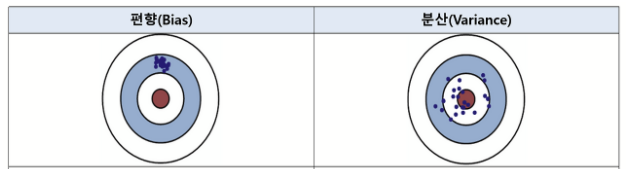

   🎯 편향(Bias) — 왼쪽 그림

- 모델의 **평균 예측값이 실제 정답(조건부 기대값)**에서 얼마나 벗어났는지를 나타낸다.

점들이 한쪽으로 몰려 있으나 중심(정답)에서 벗어나 있음
→ 예측들이 서로 비슷하긴 하지만 항상 같은 방향으로 틀림

- 평균 예측값이 정답에서 멀다는 의미로 높은 편향

**과소적합(Underfitting)**과 관련

🎯 분산(Variance) — 오른쪽 그림

- 분산은 *“개별 예측들이 평균 예측값 주변에서 얼마나 흔들리는가?”*를 의미한다.

점들이 사방으로 넓게 퍼져 있음
→ 평균은 중심 근처일 수 있으나, 예측이 매우 불안정

- 학습 데이터가 조금만 바뀌어도 예측이 크게 달라짐

높은 분산, **과대적합(Overfitting)**과 관련
 
👉 비유적 설명

카메라로 사진을 찍을 때 초점을 정확히 맞추는 것은 편향을 줄이는 것에 해당하고 손떨림을 줄이는 것은 분산을 줄이는 것에 해당한다.

실무적으로 과적합 여부는 validation dataset의 loss가 더 이상 감소하지 않고, 지속적으로 증가하기 시작하는 것으로 판단하여 조기종료(early stopping)를 함
  

### 2. 배치정규화

In [2]:
# 예제 1 배치 정규화, 텐서 초기값
import torch


x = torch.FloatTensor(
    [
        [-0.6577, -0.5797, 0.6360],
        [0.7392, 0.2145, 1.523],
        [0.2432, 0.5662, 0.322]
    ]
)
x.shape # 배치크기 3, 피처수 3

torch.Size([3, 3])

In [4]:
# 예제 2 배치 정규화 수행 - 평균과 분산(표준편차)를 이용한 표준화
from torch import nn
print(nn.BatchNorm1d(3)(x)) # 3은 피처수

tensor([[-1.3246, -1.3492, -0.3756],
        [ 1.0912,  0.3077,  1.3685],
        [ 0.2334,  1.0415, -0.9930]], grad_fn=<NativeBatchNormBackward0>)


### 3. 가중치 초기화

In [6]:
# 예제 3 가중치 초기화 제이비어 초기화
from torch import nn


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(1, 2),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(2, 1)
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.layer[0].weight) # 제이비어 초기화
        self.layer[0].bias.data.fill_(0.01)

        nn.init.xavier_uniform_(self.fc.weight)
        self.fc.bias.data.fill_(0.01)


model = Net()

In [8]:
# 예제 4 # 모듈을 사용한 가중치 초기화
from torch import nn


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(1, 2),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(2, 1)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.constant_(module.bias, 0.01)
        print(f"Apply : {module}")


model = Net()

Apply : Linear(in_features=1, out_features=2, bias=True)
Apply : Sigmoid()
Apply : Sequential(
  (0): Linear(in_features=1, out_features=2, bias=True)
  (1): Sigmoid()
)
Apply : Linear(in_features=2, out_features=1, bias=True)
Apply : Net(
  (layer): Sequential(
    (0): Linear(in_features=1, out_features=2, bias=True)
    (1): Sigmoid()
  )
  (fc): Linear(in_features=2, out_features=1, bias=True)
)


### 4 정칙화 

#### - L1 정칙화와 L2 정칙화

In [1]:
# 예제 5, 6 직용 전 - 예제 35 ~ 43 중에서
import torch
import pandas as pd
# import torch.nn as nn
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)
        self.x = df.iloc[:, 0].values
        self.y = df.iloc[:, 1].values
        self.length = len(df)

    def __getitem__(self, index):
        x = torch.FloatTensor([self.x[index] ** 2, self.x[index]])
        y = torch.FloatTensor([self.y[index]])
        return x, y

    def __len__(self):
        return self.length

class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(2, 1)

    def forward(self, x):
        x = self.layer(x)
        return x

In [2]:
from torch.utils.data import random_split

# 전체 데이터셋
full_dataset = CustomDataset('../datasets/non_linear.csv')

# 비율
total_len = len(full_dataset)
train_len = int(total_len * 0.8)
val_len   = int(total_len * 0.1)
test_len  = total_len - train_len - val_len

# 랜덤 분할 (재현성 원하면 generator에 seed)
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(42)
)

In [5]:
train_dataloader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, drop_last=False # 128을 32로 바꿈 True
)

val_dataloader = DataLoader(
    val_dataset, batch_size=32, shuffle=False
)

test_dataloader = DataLoader(
    test_dataset, batch_size=32, shuffle=False
)


In [7]:
train_used = len(train_dataloader) * train_dataloader.batch_size
val_used   = len(val_dataloader)   * val_dataloader.batch_size
test_used  = len(test_dataloader)  * test_dataloader.batch_size

print(f"Train dataset samples: {len(train_dataset)}")
print(f"Val dataset samples  : {len(val_dataset)}")
print(f"Test dataset samples : {len(test_dataset)}")

print(f"Total samples        : {len(train_dataset) + len(val_dataset) + len(test_dataset)}")
## 128만 쓰고,32개는 사실상 버려짐. 20, 20개만 쓰임. ㅋ

Train dataset samples: 160
Val dataset samples  : 20
Test dataset samples : 20
Total samples        : 200


In [9]:
# 학습 및 검증
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CustomModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

for epoch in range(10000):
    model.train()
    cost = 0.0

    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y) # criterion = nn.MSELoss() -> 배치당 평균 S.E

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss.detach()

    cost = cost / len(train_dataloader)

    # 🔹 검증(loss는 data_loss만!)
    if (epoch + 1) % 1000 == 0:
        model.eval()
        val_cost = 0.0

        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                val_output = model(x_val)
                val_loss = criterion(val_output, y_val)
                val_cost += val_loss

        val_cost = val_cost / len(val_dataloader)

        print(
            f"Epoch {epoch+1:4d} | "
            f"train_loss: {cost.item():.3f} | "
            f"val_loss: {val_cost.item():.3f}"
        )


Epoch 1000 | train_loss: 0.160 | val_loss: 0.126
Epoch 2000 | train_loss: 0.107 | val_loss: 0.087
Epoch 3000 | train_loss: 0.086 | val_loss: 0.079
Epoch 4000 | train_loss: 0.079 | val_loss: 0.083
Epoch 5000 | train_loss: 0.076 | val_loss: 0.079
Epoch 6000 | train_loss: 0.074 | val_loss: 0.076
Epoch 7000 | train_loss: 0.074 | val_loss: 0.078
Epoch 8000 | train_loss: 0.074 | val_loss: 0.082
Epoch 9000 | train_loss: 0.073 | val_loss: 0.079
Epoch 10000 | train_loss: 0.074 | val_loss: 0.079


In [10]:
# 테스트
model.eval()
test_cost = 0.0

with torch.no_grad():
    for x_test, y_test in test_dataloader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        test_output = model(x_test)
        test_loss = criterion(test_output, y_test)
        test_cost += test_loss

test_cost = test_cost / len(test_dataloader)

print(f"\nFinal TEST loss (data_loss only): {test_cost.item():.3f}")


Final TEST loss (data_loss only): 0.096


In [11]:
# 학습 및 검증 (L1 정칙화 포함)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CustomModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

_lambda = 0.5

for epoch in range(10000):
    model.train()
    train_total = 0.0      # total_loss 누적 (data + reg)
    train_data = 0.0       # data_loss 누적 (정칙화 제외)
    train_l1 = 0.0         # l1_loss 누적 (raw)

    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        # 1) forward
        output = model(x)

        # 2) data loss
        data_loss = criterion(output, y)

        # 3) L1 정칙화(학습 목적함수에만 포함)
        l1_loss = sum(p.abs().sum() for p in model.parameters())
        reg_loss = _lambda * l1_loss

        # 4) total loss (optimizer가 최소화)
        loss = data_loss + reg_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 누적(그래프 끊기)
        train_total += loss.detach()
        train_data  += data_loss.detach()
        train_l1    += l1_loss.detach()

    # epoch 평균
    train_total = train_total / len(train_dataloader)
    train_data  = train_data  / len(train_dataloader)
    train_l1    = train_l1    / len(train_dataloader)
    train_reg   = _lambda * train_l1

    # 🔹 검증: data_loss만(정칙화 제외)
    if (epoch + 1) % 1000 == 0:
        model.eval()
        val_cost = 0.0

        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                val_output = model(x_val)
                val_loss = criterion(val_output, y_val)  # 정칙화 제외
                val_cost += val_loss

        val_cost = val_cost / len(val_dataloader)

        # ✅ 기존 비교 포인트 유지한 출력
        print(f"Epoch {epoch+1:4d}")
        print(f"  train_data_loss (정칙화 제외)      : {train_data.item():.6f}")
        print(f"  train_l1_loss(raw, |w| 합)         : {train_l1.item():.6f}")
        print(f"  train_lambda*l1 (정칙화 기여분)    : {train_reg.item():.6f}")
        print(f"  train_total_loss (optimizer 목표)  : {train_total.item():.6f}")
        print(f"  val_loss (정칙화 제외, 비교 기준)  : {val_cost.item():.6f}")
        print("-" * 50)


Epoch 1000
  train_data_loss (정칙화 제외)      : 0.094007
  train_l1_loss(raw, |w| 합)         : 5.076740
  train_lambda*l1 (정칙화 기여분)    : 2.538370
  train_total_loss (optimizer 목표)  : 2.632378
  val_loss (정칙화 제외, 비교 기준)  : 0.089994
--------------------------------------------------
Epoch 2000
  train_data_loss (정칙화 제외)      : 0.124156
  train_l1_loss(raw, |w| 합)         : 4.956949
  train_lambda*l1 (정칙화 기여분)    : 2.478474
  train_total_loss (optimizer 목표)  : 2.602631
  val_loss (정칙화 제외, 비교 기준)  : 0.106729
--------------------------------------------------
Epoch 3000
  train_data_loss (정칙화 제외)      : 0.149430
  train_l1_loss(raw, |w| 합)         : 4.881165
  train_lambda*l1 (정칙화 기여분)    : 2.440582
  train_total_loss (optimizer 목표)  : 2.590012
  val_loss (정칙화 제외, 비교 기준)  : 0.117040
--------------------------------------------------
Epoch 4000
  train_data_loss (정칙화 제외)      : 0.168363
  train_l1_loss(raw, |w| 합)         : 4.833917
  train_lambda*l1 (정칙화 기여분)    : 2.416958
  train_total_loss (

In [12]:
# =========================
# TEST 평가 (정칙화 제외)
# =========================
model.eval()
test_cost = 0.0

with torch.no_grad():
    for x_test, y_test in test_dataloader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        test_output = model(x_test)
        test_loss = criterion(test_output, y_test)  # ❌ 정칙화 제외
        test_cost += test_loss

test_cost = test_cost / len(test_dataloader)

print(f"\nFinal TEST loss (data_loss only, with L1 regularization): {test_cost.item():.6f}")



Final TEST loss (data_loss only, with L1 regularization): 0.270707


In [13]:
# 학습 및 검증 (L2 정칙화 포함)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CustomModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

_lambda = 0.5   # ⚠️ L2도 크면 과도할 수 있음 (실험 후 줄이기 권장)

for epoch in range(10000):
    model.train()
    train_total = 0.0      # total_loss 누적 (data + reg)
    train_data = 0.0       # data_loss 누적 (정칙화 제외)
    train_l2 = 0.0         # l2_loss 누적 (raw)

    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        # 1) forward
        output = model(x)

        # 2) data loss
        data_loss = criterion(output, y)

        # 3) L2 정칙화 (가중치 제곱합)
        l2_loss = sum(p.pow(2.0).sum() for p in model.parameters())
        reg_loss = _lambda * l2_loss

        # 4) total loss (optimizer가 최소화)
        loss = data_loss + reg_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 누적(그래프 끊기)
        train_total += loss.detach()
        train_data  += data_loss.detach()
        train_l2    += l2_loss.detach()

    # epoch 평균
    train_total = train_total / len(train_dataloader)
    train_data  = train_data  / len(train_dataloader)
    train_l2    = train_l2    / len(train_dataloader)
    train_reg   = _lambda * train_l2

    # 🔹 검증: data_loss만 (정칙화 제외)
    if (epoch + 1) % 1000 == 0:
        model.eval()
        val_cost = 0.0

        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                val_output = model(x_val)
                val_loss = criterion(val_output, y_val)  # 정칙화 제외
                val_cost += val_loss

        val_cost = val_cost / len(val_dataloader)

        # ✅ 비교 포인트 유지
        print(f"Epoch {epoch+1:4d}")
        print(f"  train_data_loss (정칙화 제외)      : {train_data.item():.6f}")
        print(f"  train_l2_loss(raw, w^2 합)         : {train_l2.item():.6f}")
        print(f"  train_lambda*l2 (정칙화 기여분)    : {train_reg.item():.6f}")
        print(f"  train_total_loss (optimizer 목표)  : {train_total.item():.6f}")
        print(f"  val_loss (정칙화 제외, 비교 기준)  : {val_cost.item():.6f}")
        print("-" * 50)


Epoch 1000
  train_data_loss (정칙화 제외)      : 0.141949
  train_l2_loss(raw, w^2 합)         : 12.477249
  train_lambda*l2 (정칙화 기여분)    : 6.238625
  train_total_loss (optimizer 목표)  : 6.380574
  val_loss (정칙화 제외, 비교 기준)  : 0.128519
--------------------------------------------------
Epoch 2000
  train_data_loss (정칙화 제외)      : 0.126422
  train_l2_loss(raw, w^2 합)         : 12.491250
  train_lambda*l2 (정칙화 기여분)    : 6.245625
  train_total_loss (optimizer 목표)  : 6.372047
  val_loss (정칙화 제외, 비교 기준)  : 0.120374
--------------------------------------------------
Epoch 3000
  train_data_loss (정칙화 제외)      : 0.122507
  train_l2_loss(raw, w^2 합)         : 12.495752
  train_lambda*l2 (정칙화 기여분)    : 6.247876
  train_total_loss (optimizer 목표)  : 6.370383
  val_loss (정칙화 제외, 비교 기준)  : 0.117898
--------------------------------------------------
Epoch 4000
  train_data_loss (정칙화 제외)      : 0.121057
  train_l2_loss(raw, w^2 합)         : 12.501787
  train_lambda*l2 (정칙화 기여분)    : 6.250894
  train_total_lo

In [14]:
# =========================
# TEST 평가 (정칙화 제외)
# =========================
model.eval()
test_cost = 0.0

with torch.no_grad():
    for x_test, y_test in test_dataloader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        test_output = model(x_test)
        test_loss = criterion(test_output, y_test)  # ❌ 정칙화 제외
        test_cost += test_loss

test_cost = test_cost / len(test_dataloader)

print(f"\nFinal TEST loss (data_loss only, with L2 regularization): {test_cost.item():.6f}")


Final TEST loss (data_loss only, with L2 regularization): 0.199244


### 가중치 감쇠

In [21]:
# 학습 및 검증
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CustomModel().to(device)
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.0001) 
# 가중치 감쇠 weight_decay=0.01
optimizer = optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.01)

for epoch in range(10000):
    model.train()
    cost = 0.0

    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss.detach()

    cost = cost / len(train_dataloader)

    # 🔹 검증(loss는 data_loss만!)
    if (epoch + 1) % 1000 == 0:
        model.eval()
        val_cost = 0.0

        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                val_output = model(x_val)
                val_loss = criterion(val_output, y_val)
                val_cost += val_loss

        val_cost = val_cost / len(val_dataloader)

        print(
            f"Epoch {epoch+1:4d} | "
            f"train_loss: {cost.item():.3f} | "
            f"val_loss: {val_cost.item():.3f}"
        )


Epoch 1000 | train_loss: 0.104 | val_loss: 0.089
Epoch 2000 | train_loss: 0.085 | val_loss: 0.078
Epoch 3000 | train_loss: 0.078 | val_loss: 0.081
Epoch 4000 | train_loss: 0.076 | val_loss: 0.079
Epoch 5000 | train_loss: 0.075 | val_loss: 0.085
Epoch 6000 | train_loss: 0.074 | val_loss: 0.082
Epoch 7000 | train_loss: 0.073 | val_loss: 0.079
Epoch 8000 | train_loss: 0.075 | val_loss: 0.081
Epoch 9000 | train_loss: 0.074 | val_loss: 0.077
Epoch 10000 | train_loss: 0.076 | val_loss: 0.078


In [23]:
# =========================
# TEST 평가 (data_loss only)
# =========================
model.eval()
test_cost = 0.0

with torch.no_grad():
    for x_test, y_test in test_dataloader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        test_output = model(x_test)
        test_loss = criterion(test_output, y_test)  # ✅ 정칙화/weight_decay 제외
        test_cost += test_loss

test_cost = test_cost / len(test_dataloader)

print(f"\nFinal TEST loss (data_loss only, with weight decay=0.01): {test_cost.item():.6f}")


Final TEST loss (data_loss only, with weight decay=0.01): 0.095343


### 모멘텀

In [26]:
optimizer = optim.SGD(
    model.parameters(),
    lr=0.0001,
    momentum=0.9   # ✅ 모멘텀 추가
)

# =========================
# 학습 및 검증 (Momentum)
# =========================
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CustomModel().to(device)
criterion = nn.MSELoss()

# ✅ momentum 추가 (weight_decay 없음)
optimizer = optim.SGD(
    model.parameters(),
    lr=0.0001,
    momentum=0.9
)

for epoch in range(10000):
    model.train()
    cost = 0.0

    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss.detach()

    cost = cost / len(train_dataloader)

    # 🔹 검증 (data_loss only)
    if (epoch + 1) % 1000 == 0:
        model.eval()
        val_cost = 0.0

        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                val_output = model(x_val)
                val_loss = criterion(val_output, y_val)
                val_cost += val_loss

        val_cost = val_cost / len(val_dataloader)

        print(
            f"Epoch {epoch+1:4d} | "
            f"train_loss: {cost.item():.3f} | "
            f"val_loss: {val_cost.item():.3f}"
        )


Epoch 1000 | train_loss: 0.075 | val_loss: 0.077
Epoch 2000 | train_loss: 0.080 | val_loss: 0.077
Epoch 3000 | train_loss: 0.075 | val_loss: 0.083
Epoch 4000 | train_loss: 0.079 | val_loss: 0.088
Epoch 5000 | train_loss: 0.077 | val_loss: 0.076
Epoch 6000 | train_loss: 0.082 | val_loss: 0.077
Epoch 7000 | train_loss: 0.077 | val_loss: 0.103
Epoch 8000 | train_loss: 0.076 | val_loss: 0.082
Epoch 9000 | train_loss: 0.074 | val_loss: 0.080
Epoch 10000 | train_loss: 0.083 | val_loss: 0.075


In [28]:
# =========================
# TEST 평가 (Momentum, data_loss only)
# =========================
model.eval()
test_cost = 0.0

with torch.no_grad():
    for x_test, y_test in test_dataloader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        test_output = model(x_test)
        test_loss = criterion(test_output, y_test)  # ✅ data_loss only
        test_cost += test_loss

test_cost = test_cost / len(test_dataloader)

print(
    f"\nFinal TEST loss (data_loss only, with SGD momentum=0.9): "
    f"{test_cost.item():.6f}"
)



Final TEST loss (data_loss only, with SGD momentum=0.9): 0.092824


### 엘라스틱 넷

In [39]:
# =========================
# 학습 및 검증 (Elastic Net)
# =========================
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CustomModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

"""
# 🔹 Elastic Net 계수
lambda_l1 = 1e-3
lambda_l2 = 1e-3
Final TEST loss (data_loss only, with Elastic Net (λ1=0.001, λ2=0.001)): 0.094662
"""

# 🔹 Elastic Net 설정 (비교 실험용)
_lambda = 0.5     # ✅ 총 정칙화 강도 (앞의 L1/L2 실험과 동일)
alpha = 0.5       # ✅ L1 비율 (0.0=L2 only, 1.0=L1 only)

for epoch in range(10000):
    model.train()

    train_total = 0.0
    train_data  = 0.0
    train_l1    = 0.0
    train_l2    = 0.0

    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        # 1️⃣ forward
        output = model(x)
        data_loss = criterion(output, y)

        # 2️⃣ Elastic Net 정칙화
        l1_loss = sum(p.abs().sum() for p in model.parameters())
        l2_loss = sum(p.pow(2).sum() for p in model.parameters())

        '''
        reg_loss = lambda_l1 * l1_loss + lambda_l2 * l2_loss
        loss = data_loss + reg_loss
        '''
        reg_loss = _lambda * (alpha * l1_loss + (1 - alpha) * l2_loss)  # ✅ 수정
        loss = data_loss + reg_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 누적
        train_total += loss.detach()
        train_data  += data_loss.detach()
        train_l1    += l1_loss.detach()
        train_l2    += l2_loss.detach()

    # epoch 평균
    n = len(train_dataloader)
    train_total /= n
    train_data  /= n
    train_l1    /= n
    train_l2    /= n

    # 🔹 검증 (data_loss only)
    if (epoch + 1) % 1000 == 0:
        model.eval()
        val_cost = 0.0

        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                val_output = model(x_val)
                val_cost += criterion(val_output, y_val)

        val_cost /= len(val_dataloader)

        print(f"Epoch {epoch+1:4d}")
        print(f"  train_data_loss          : {train_data.item():.6f}")
        print(f"  train_l1_loss(raw)       : {train_l1.item():.6f}")
        print(f"  train_l2_loss(raw)       : {train_l2.item():.6f}")
        print(f"  train_reg_loss (정칙화 기여)  : {(_lambda*(alpha*train_l1 + (1-alpha)*train_l2)).item():.6f}")
        print(f"  train_total_loss         : {train_total.item():.6f}")
        print(f"  val_loss (data only)     : {val_cost.item():.6f}")
        

        print("-" * 50)


Epoch 1000
  train_data_loss          : 0.133666
  train_l1_loss(raw)       : 4.941679
  train_l2_loss(raw)       : 12.499845
  train_reg_loss (정칙화 기여)  : 4.360381
  train_total_loss         : 4.494047
  val_loss (data only)     : 0.116992
--------------------------------------------------
Epoch 2000
  train_data_loss          : 0.134250
  train_l1_loss(raw)       : 4.945109
  train_l2_loss(raw)       : 12.503253
  train_reg_loss (정칙화 기여)  : 4.362091
  train_total_loss         : 4.496340
  val_loss (data only)     : 0.114768
--------------------------------------------------
Epoch 3000
  train_data_loss          : 0.132043
  train_l1_loss(raw)       : 4.946620
  train_l2_loss(raw)       : 12.503938
  train_reg_loss (정칙화 기여)  : 4.362639
  train_total_loss         : 4.494682
  val_loss (data only)     : 0.121766
--------------------------------------------------
Epoch 4000
  train_data_loss          : 0.131097
  train_l1_loss(raw)       : 4.947143
  train_l2_loss(raw)       : 12.502881
 

In [40]:
# =========================
# TEST 평가 (Elastic Net)
# =========================
model.eval()
test_cost = 0.0

with torch.no_grad():
    for x_test, y_test in test_dataloader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        test_output = model(x_test)
        test_cost += criterion(test_output, y_test)

test_cost /= len(test_dataloader)

print(
    f"\nFinal TEST loss (data_loss only, with Elastic Net "
    f"(λ1={lambda_l1}, λ2={lambda_l2})): "
    f"{test_cost.item():.6f}"
)



Final TEST loss (data_loss only, with Elastic Net (λ1=0.001, λ2=0.001)): 0.215546


### 그래디언트 클리핑

In [54]:
# =========================
# 학습 및 검증 (Gradient Clipping)
# 그래디언트 클리핑이란 gradient의 크기(norm)가 기준을 넘으면, 그 크기를 기준값까지 “줄여서(clipping해서)” 쓰라는 뜻
# =========================
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CustomModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

max_norm = 0.1  # 🔹 gradient clipping threshold

for epoch in range(10000):
    model.train()
    train_cost = 0.0

    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        # 1️⃣ forward
        output = model(x)
        loss = criterion(output, y)

        # 2️⃣ backward
        optimizer.zero_grad()
        loss.backward()

        # 3️⃣ gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
# 오류확인을 위해 주석처리도 해봄
        
        # 4️⃣ update
        optimizer.step()

        train_cost += loss.detach()

    train_cost /= len(train_dataloader)

    # =========================
    # 검증 (data_loss only)
    # =========================
    if (epoch + 1) % 1000 == 0:
        model.eval()
        val_cost = 0.0

        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                val_output = model(x_val)
                val_loss = criterion(val_output, y_val)
                val_cost += val_loss

        val_cost /= len(val_dataloader)

        print(
            f"Epoch {epoch+1:4d} | "
            f"train_loss: {train_cost.item():.6f} | "
            f"val_loss: {val_cost.item():.6f}"
        )


Epoch 1000 | train_loss: 14329.361328 | val_loss: 10976.258789
Epoch 2000 | train_loss: 13800.241211 | val_loss: 10555.369141
Epoch 3000 | train_loss: 13279.965820 | val_loss: 10141.872070
Epoch 4000 | train_loss: 12769.778320 | val_loss: 9736.689453
Epoch 5000 | train_loss: 12269.634766 | val_loss: 9339.815430
Epoch 6000 | train_loss: 11779.506836 | val_loss: 8951.236328
Epoch 7000 | train_loss: 11299.454102 | val_loss: 8570.963867
Epoch 8000 | train_loss: 10829.367188 | val_loss: 8198.981445
Epoch 9000 | train_loss: 10369.318359 | val_loss: 7835.297852
Epoch 10000 | train_loss: 9919.351562 | val_loss: 7479.920410


In [55]:
# =========================
# TEST 평가 (Gradient Clipping 모델)
# =========================
model.eval()
test_cost = 0.0

with torch.no_grad():
    for x_test, y_test in test_dataloader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        test_output = model(x_test)
        test_loss = criterion(test_output, y_test)  # ✅ data_loss only
        test_cost += test_loss

test_cost /= len(test_dataloader)

print(
    f"\nFinal TEST loss (data_loss only, with gradient clipping "
    f"(max_norm={max_norm})): {test_cost.item():.6f}"
)



Final TEST loss (data_loss only, with gradient clipping (max_norm=0.1)): 11839.280273


### 드롭아웃

In [71]:
# 모델 수정
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 10)   # 입력: 2, 출력 2를 10으로 변경
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.layer2 = nn.Linear(10, 1)   # 출력: 1 입력 2를 출력 10으로 변경

    def forward(self, x):
        x = self.layer1(x)
        x = self.act(x)
        x = self.dropout(x)              # 🔹 학습 시에만 활성
        x = self.layer2(x)
        return x


In [73]:
# =========================
# 학습 및 검증 (Dropout)
# =========================
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CustomModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

for epoch in range(10000):
    model.train()   # 🔹 Dropout ON
    train_cost = 0.0

    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        # forward
        output = model(x)
        loss = criterion(output, y)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_cost += loss.detach()

    train_cost /= len(train_dataloader)

    # 🔹 검증 (Dropout OFF)
    if (epoch + 1) % 1000 == 0:
        model.eval()
        val_cost = 0.0

        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                val_output = model(x_val)
                val_loss = criterion(val_output, y_val)
                val_cost += val_loss

        val_cost /= len(val_dataloader)

        print(
            f"Epoch {epoch+1:4d} | "
            f"train_loss: {train_cost.item():.6f} | "
            f"val_loss: {val_cost.item():.6f}"
        )


Epoch 1000 | train_loss: 9113.669922 | val_loss: 4718.146484
Epoch 2000 | train_loss: 5783.265137 | val_loss: 2096.836670
Epoch 3000 | train_loss: 4765.569824 | val_loss: 1565.850464
Epoch 4000 | train_loss: 4319.819824 | val_loss: 1231.080078
Epoch 5000 | train_loss: 3497.707520 | val_loss: 725.084229
Epoch 6000 | train_loss: 3531.962891 | val_loss: 731.713928
Epoch 7000 | train_loss: 3518.367676 | val_loss: 690.431763
Epoch 8000 | train_loss: 3079.315918 | val_loss: 459.063934
Epoch 9000 | train_loss: 3147.830811 | val_loss: 622.875793
Epoch 10000 | train_loss: 3839.420410 | val_loss: 1277.528809


In [74]:
# =========================
# TEST 평가 (Dropout)
# =========================
model.eval()   # 🔹 Dropout OFF
test_cost = 0.0

with torch.no_grad():
    for x_test, y_test in test_dataloader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        test_output = model(x_test)
        test_loss = criterion(test_output, y_test)  # data_loss only
        test_cost += test_loss

test_cost /= len(test_dataloader)

print(
    f"\nFinal TEST loss (data_loss only, with Dropout p=0.5): "
    f"{test_cost.item():.6f}"
)



Final TEST loss (data_loss only, with Dropout p=0.5): 3136.483154


In [ ]:
🔎 정칙화 및 최적화 기법 실험 최종 정리

1️⃣ Loss와 정칙화의 역할 구분 (핵심 전제)
구분	data loss	regularization (L1, L2 등)
목적	예측 정확도	모델 복잡도 제어
학습 시	✔ 포함	✔ 포함
평가(Test) 시	✔ 포함	❌ 제외

학습 시 loss: data_loss + regularization

평가(test) 시 loss: data_loss only
👉 정칙화는 train/val loss가 아니라, test data loss로 성공 여부를 판단해야 함.

2️⃣ 실험 결과 요약

(동일 기준: test data_loss only)
2️⃣ 실험 결과 요약 (같은 기준: test data_loss)
정칙화 전: Final TEST loss (data_loss only): 0.096                                   baseline
L1 정칙화 후: Final TEST loss (data_loss only, with L1 regularization): 0.270707 -> ❌ 크게 악화
L2 정칙화 후: Final TEST loss (data_loss only, with L2 regularization): 0.199244 -> ❌ 악화
엘라스틱넷: Final TEST loss (data_loss only, with Elastic Net (λ1=0.001, λ2=0.001)): 0.215546 ❌ 악화
# 단 🔹 Elastic Net 계수
lambda_l1 = 1e-3
lambda_l2 = 1e-3 수치를 잘 조작하면 좋아짐. 
Final TEST loss (data_loss only, with Elastic Net (λ1=0.001, λ2=0.001)): 0.094662 ✔ 소폭 개선
가중치 감쇠: Final TEST loss (data_loss only, with weight decay=0.01): 0.095343 ->✔ 소폭 개선
모멘텀 적용: Final TEST loss (data_loss only, with SGD momentum=0.9): 0.092824 -> ✔ 가장 개선
그래드언트클리핑: Final TEST loss (data_loss only, with gradient clipping (max_norm=0.1)): 11839.280273 -> ❌ 학습 붕괴(가장 심각)
드롭아웃: Final TEST loss (data_loss only, with Dropout p=0.5): 3136.483154 ❌ 심각한 성능 붕괴

3️⃣ ❗ 소결 (핵심 판단)

이 데이터와 모델, 그리고 현재 설정에서는 L1·L2 정칙화 등은 일반화 성능을 개선하지 못했다.

이는 정칙화가 필요하지 않은 상황이었거나 정칙화 강도(λ)가 과도했기 때문이다.

4️⃣ 왜 이런 상황이 발생했는가? (왜 정칙화가 비효과적이었는가?)
(1) λ가 과도하게 큼
_lambda = 0.5 는 MSE 스케일 대비 매우 큰 값

L1
비미분점 + 강한 패널티
작은 모델에서 표현력 급격히 훼손

L2
과도한 shrinkage(수축) 발생
👉 정칙화 개념의 실패가 아니라, 하이퍼파라미터 튜닝 실패

(2) 데이터 자체가 이미 과적합 상태가 아님

정칙화 없이도 train / val / test loss 모두 안정

test loss ≈ 0.096
고칠 과적합이 존재하지 않음
👉 문제가 없는데 제약을 건 상황

(3) 이 문제에서는 feature를 줄이는 것이 오히려 손해

입력 feature: [x², x] (2개뿐)
L1의 본질: sparsity / feature selection

하지만: 두 feature 모두 의미 있음

하나라도 약화 → 표현력 손실 → 성능 저하
👉 L1의 장점이 단점으로 작동한 전형적인 사례

(4) Gradient Clipping & Dropout이 망가진 이유 (보완 설명)

🔹 Gradient Clipping
원래 목적: gradient 폭발 방지

하지만: 이 문제는 폭발 문제가 없음

max_norm=0.1 → 학습 신호 자체 제거 
👉 underfitting → 학습 붕괴
그래디언트 클리핑이란 gradient의 크기(norm)가 기준을 넘으면, 그 크기를 기준값까지 “줄여서(clipping해서)” 쓰라는 뜻 
결과적으로 잘 작동하던 그래디언트를 과도하게 제약해서 학습이 붕괴됨.

🔹 Dropout
회귀 문제 + 데이터 적음 + 출력 1차원
Dropout(p=0.5):
출력 분산을 인위적으로 흔듦

MSE 기반 회귀에서 치명적
👉 노이즈 주입 → 예측 자체 붕괴

5️⃣ 회고

정칙화는 항상 성능을 높여주는 마법이 아니라,
과적합이 존재하고, 적절한 강도로 적용될 때만 효과가 있다.
이번 실험에서는 그 조건이 성립하지 않았다.

L1 / L2 / Dropout / Gradient Clipping → 과도하거나 부적절

Weight Decay, Momentum → 약한 제어로 소폭 개선

가장 중요한 것은 문제·데이터·모델에 맞는 기법 선택

이 실험의 진짜 성과는 정칙화를 언제 쓰지 말아야 하는지를 확인했음.